<a href="https://colab.research.google.com/github/sir-sauc3/comp215-Project1/blob/main/Sos%26Roberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this is our key: k_w26fb6h9
# api url top 250 movies: https://imdb-api.com/en/API/Top250Movies/k_w26fb6h9
# api url for movie casst: https://imdb-api.com/en/API/FullCast/k_w26fb6h9/${movie ID}

In [2]:
import json, requests
from pprint import pprint
from dataclasses import dataclass
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np

In [3]:
#Making classes for easier data wrangling 
@dataclass
class Actor:
  name : str
  id : str
  image : str

  @classmethod
  def createActor(cls, name, id, image):
    return cls(name, id, image)
    

@dataclass
class Movie:
  title : str
  id : str
  image: str

  @classmethod
  def createMovie(cls, title, id, image):
    return cls(title, id, image)


In [4]:
# Making the API call for data
API_KEY = 'k_w26fb6h9'

url = f'https://imdb-api.com/en/API/Top250Movies/k_w26fb6h9'

response = requests.request("GET", url, headers={}, data={})

data = json.loads(response.text)


In [5]:
# Data prep for graph
movies = [(movie['title'],
          movie['id'],
          movie['image']) for movie in data['items']]

movie_items = [data for data in data['items']]

#collects last two crew members (actors) from 'crew' key in items
crew = [[crew['crew'].split(', ')[-2], crew['crew'].split(', ')[-1]] for crew in data['items']]
# pprint(crew) #ONE OF THE THINGS WE NEED

allActors = set() #OTHER PIECE OF DATA WE NEED

for pair in crew:
  allActors.add(pair[0])
  allActors.add(pair[1])

set_of_actors = set()
for i in range(len(crew)):
  for x in range(2): #because each crew group comes with 2 actors
    #adding actors by their 1st name and initials of 2nd coz graph labels are too long and clutter the space
    if len(crew[i][x].split(' ')) > 1: #checks if actor has more than 1 fisrt name
      set_of_actors.add(' '.join((crew[i][x].split(' ')[0], crew[i][x].split(' ')[1]))) #joins 1st name and first 2 letters of last name
    else: #if they're only referenced by one name i.e Zendaya, (thus not having an initial for 2nd name)
      set_of_actors.add(crew[i][x]) #add their one name only
  
movieid_actor =  [(movie_info['id'], (movie_info['crew'].split(', ')[-2], movie_info['crew'].split(', ')[-1])) for movie_info in movie_items]
movieid_dict =  {movie_info['id'] : (movie_info['crew'].split(', ')[-2], movie_info['crew'].split(', ')[-1]) for movie_info in movie_items}

actors_dict = {actor: set() for actor in set_of_actors}
for (key, value) in movieid_actor:
  if value[0].count(" ") == 2 or value[1].count(" ") == 2:
    continue
  actors_dict[value[0]].add(key)
  actors_dict[value[1]].add(key)

actors_dict = {k : v for k,v in actors_dict.items() if v !=set()}

movie_id = 'tt1950186' #random movie id i picked from data['items'] in 4th code block

url = f'https://imdb-api.com/en/API/FullCast/k_w26fb6h9/{movie_id}'

response = requests.request("GET", url, headers={}, data={})

data = json.loads(response.text)

fullcast=[]
fullcast = [(actor['name'],
            actor['id'],
            actor['image']) for actor in data['actors']]

MovieObjects = [Movie.createMovie(title, id, image) for (title, id, image) in movies]

ActorObjects = [Actor.createActor(name, id, image) for (name, id, image) in fullcast]

# crew, allActors
allActorsList = list(allActors)

crew = crew[:30]
allActorsList = allActorsList[:30]


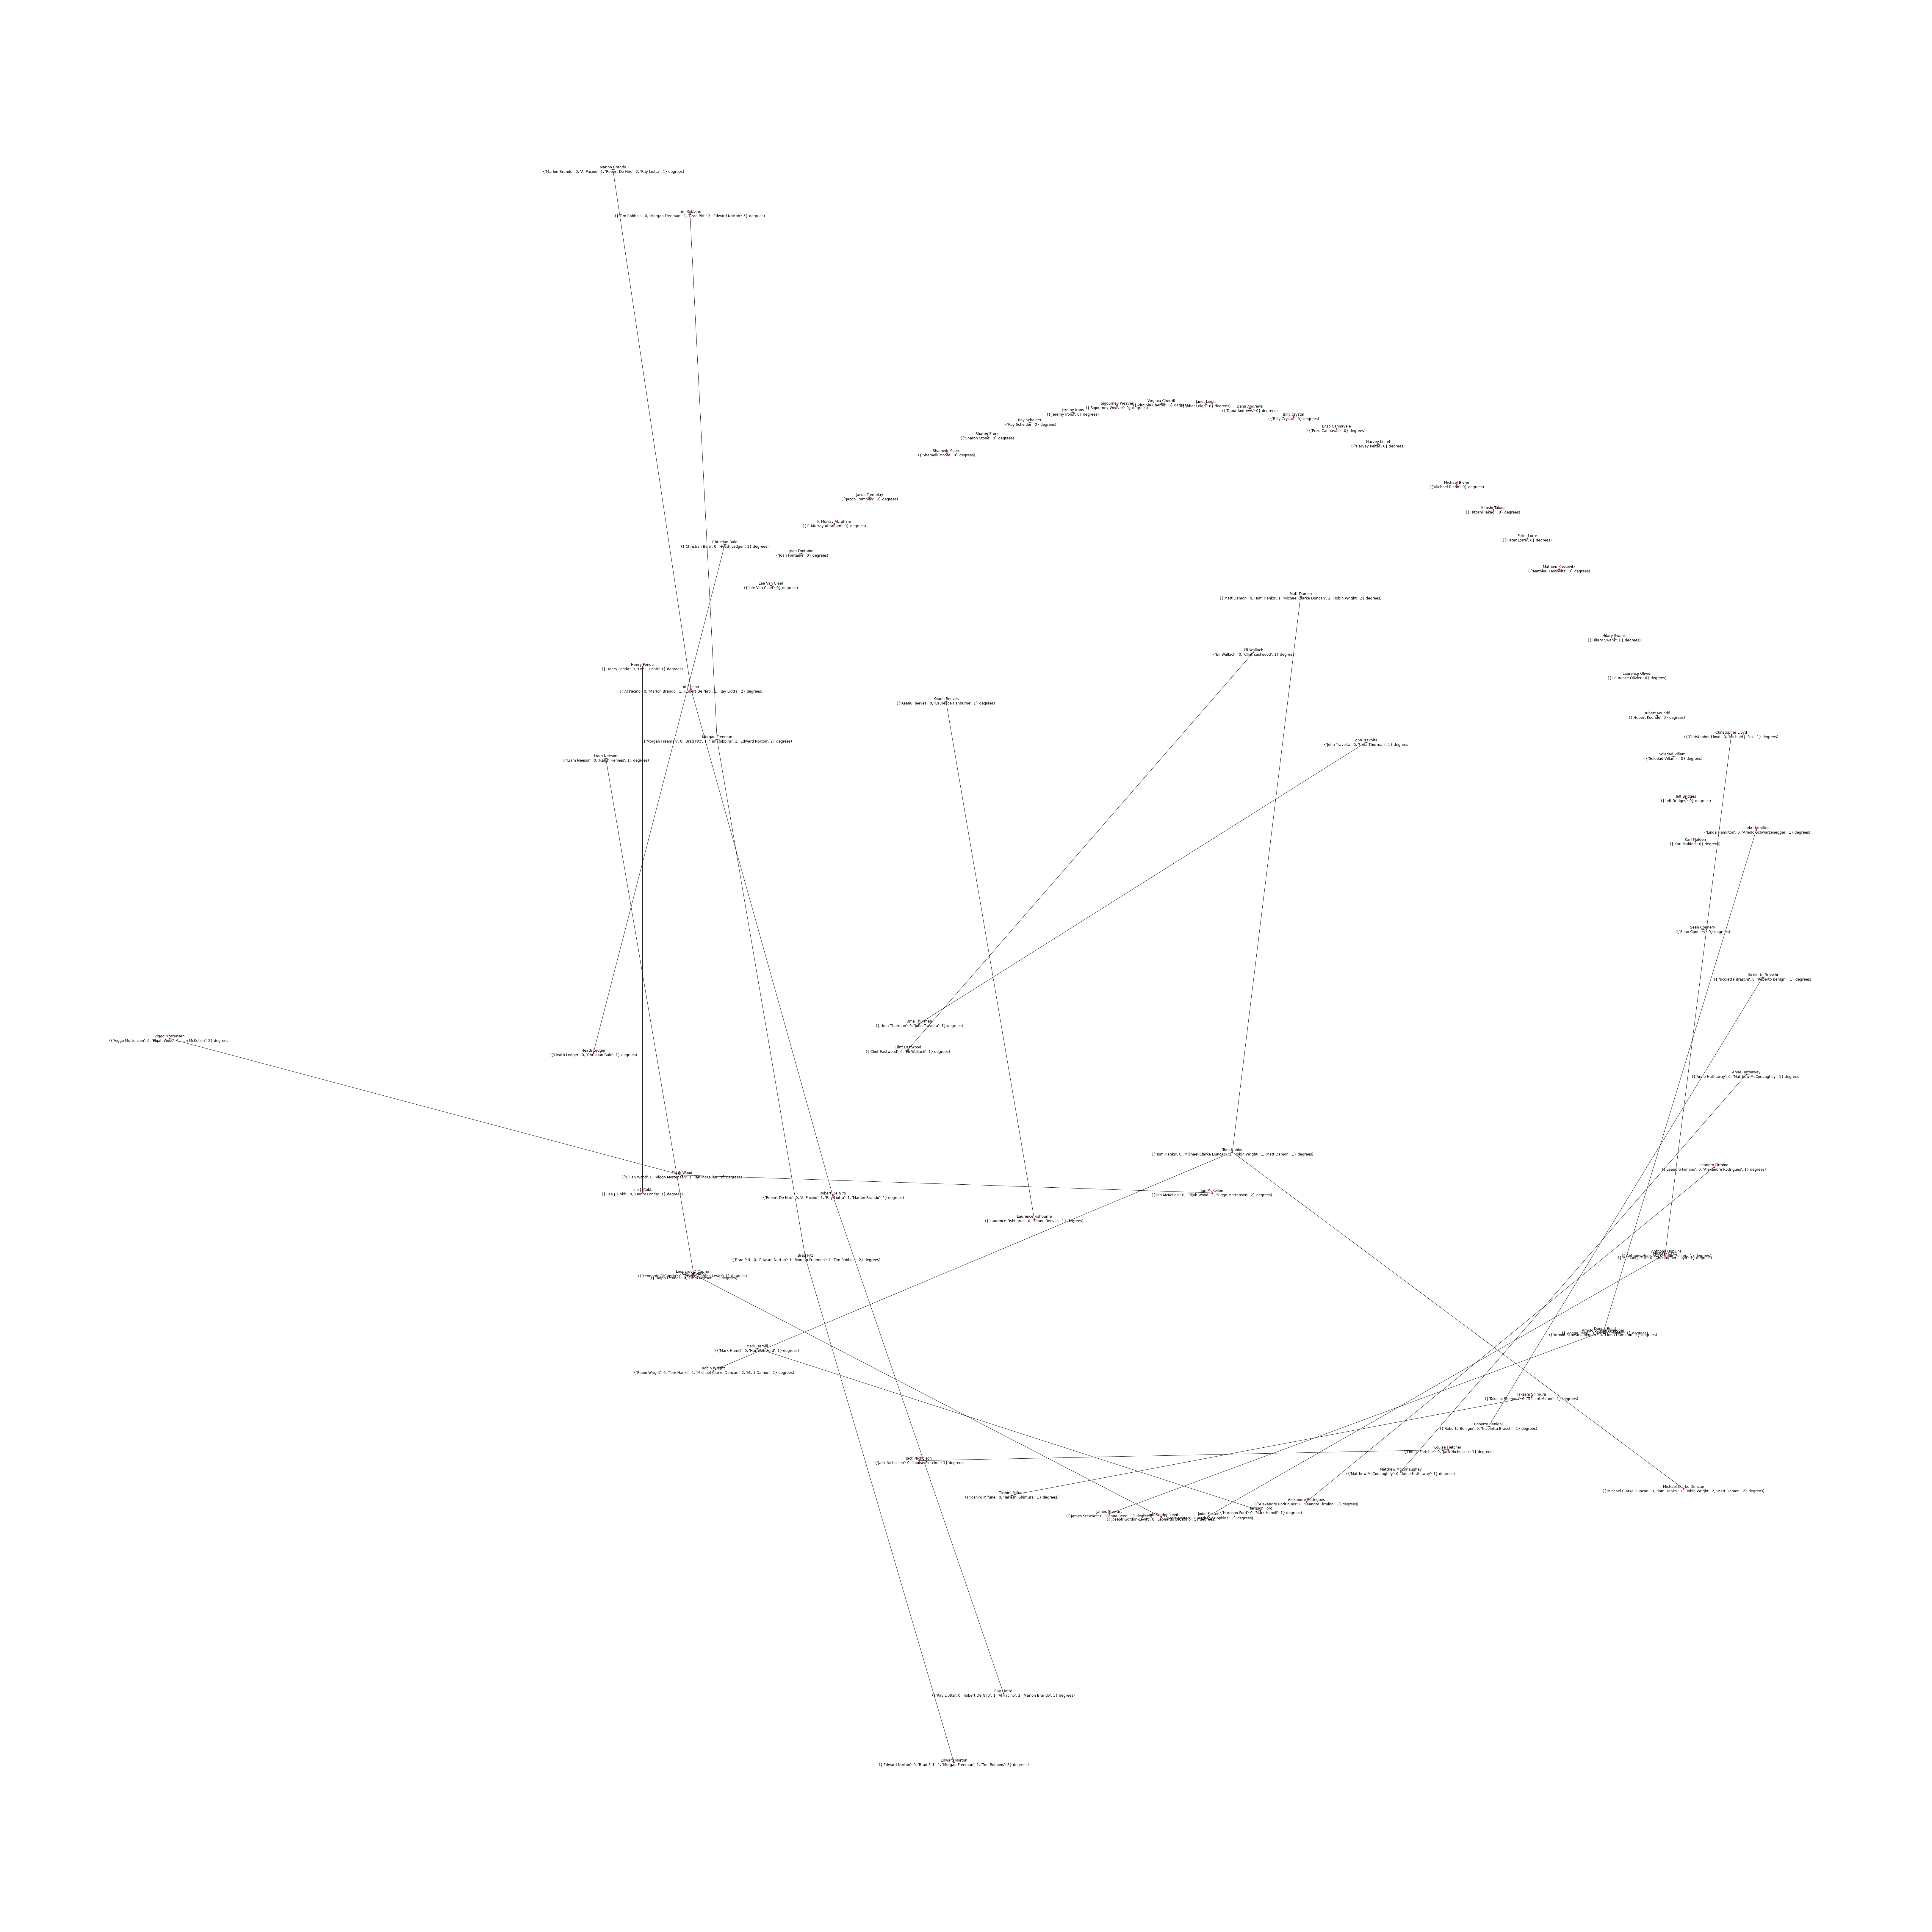

In [6]:

# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(allActorsList)

# Add edges to the graph
G.add_edges_from(crew)

# Calculate shortest path lengths between all pairs of nodes
path_lengths = dict(nx.shortest_path_length(G))

# Draw the graph with node labels indicating degree of separation
pos = nx.kamada_kawai_layout(G)
plt.figure(3,figsize=(90,90))
nx.draw(G, pos, node_color='red',
                 font_size = 2,
                 node_size=20,
                 with_labels=True)
labels = {actor: f"{actor}\n({degree} degrees)" for actor, degree in path_lengths.items()}
nx.draw_networkx_labels(G, pos, labels=labels)

# Show the graph
plt.show()

In [9]:
'''GRAPH ANALYSIS: CODE SECTION'''

def reachable_nodes(graph, start):
    """ return the set of nodes that are reachable from the given start node"""
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.neighbors(node))
    return seen

def is_connected(graph):
    """ Return True if the graph is connected, false otherwise. """
    start = next(iter(graph))   # grab the first node in the graph.  This statement will need some further explanation.
    reachable = reachable_nodes(graph, start)
    return len(reachable) == len(graph)

# Q1:
# still gotta do the clustering analysis thing


# We know the answer to this already, as we had actors with 0 connections
# but for the sake of the process, we can check
print("Is graph connected:", is_connected(G))

def is_graph_random(G, threshold=0.1):
    # generate nx's reproduction of a "random" graph and compare to ours via threshhold 
    numNodes = G.number_of_nodes()
    mumEdges = G.number_of_edges()
    randomGraph = nx.fast_gnp_random_graph(numNodes, 0.5) #using 0.5 to indicte 50/50%
    randomNumEdges = randomGraph.number_of_edges()

    if np.abs(randomNumEdges - mumEdges) / mumEdges < threshold:
        return True
    else:
        return False

print("Is graph random:", is_graph_random(G))

# Q2: *NetworkX is typically able to ue the nx.average_shortest_path_length(), but our graph is not connected.
# That's why we have to kinda play the system lol 
largest_connected = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_connected)

# compute the average shortest path length of the largest connected component
avg_path_length = nx.average_shortest_path_length(subgraph)

print("Average path length (of connected part):", avg_path_length)

Is graph connected: False
Is graph random: False
Average path length (of connected part): 1.5


### GRAPH ANALYSIS:

3 - Due to constraints in the graphical representation and data wrangling, we chose to only consider 2 actors from certain movies in the top 250. We did not use the fullCast API call, and instead relied purely on the 2 actors supplied in the Top250 API call. This severely cut down on the amount of connections each actor has on our graph - The code works the same, but the data passed through itlimited it heavily. We felt that clarity in the graphical nature of the graph was worth sacrificing the averaging number of connections per actor. For the few actors shown, some will have 0, some will have 2, 3, 4, etc. To reduce this bias, we could have passed in more data, however a graphical representation in this environment would be very ugly.****

Another bias is the usage of only the top 250 movies. Despite many of these actors being world-class actors, they undoubtedly have worked on flop movies - movies that wouldn't show up in the top 250 IMDB database. This would have increased the number of connections, as the top 250 limits the data passed once again.